In [1]:
import os
os.chdir("..")
os.getcwd()

'c:\\Users\\ADEGOKE\\Desktop\\Hybrid-Video-Recommender-System'

## Load the 1M Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline 
warnings.filterwarnings("ignore")

df_ratings = pd.read_csv("data/raw/ratings.dat", sep="::", engine="python",
                      names=["user_id", "movie_id", "rating", "timestamp"])

df_movies = pd.read_csv("data/raw/movies.dat", sep="::", engine="python",
                     names=["movie_id", "title", "genres"], encoding="latin-1")


In [3]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Check for missing values

In [5]:
df_ratings.isnull().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [6]:
df_ratings.shape

(1000209, 4)

In [7]:
df_movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [8]:
df_movies.shape

(3883, 3)

### Check for unique values

In [9]:
df_ratings["user_id"].nunique(), df_ratings["movie_id"].nunique()

(6040, 3706)

In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [11]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [12]:
df_ratings["rating"].value_counts(normalize=True)

rating
4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: proportion, dtype: float64

In [13]:
n_users = df_ratings.user_id.nunique()
n_items = df_ratings.movie_id.nunique()
density = len(df_ratings) / (n_users * n_items)

if density < 0.01:
    msg = "Excellent sparsity for ALS"
elif density < 0.05:
    msg = "Good sparsity for ALS MovieLens 1M range"
elif density < 0.10:
    msg = "Moderate sparsity - consider memory optimization"
else:
    msg = "High density - consider alternative algorithms"

print(msg)
density

Good sparsity for ALS MovieLens 1M range


0.044683625622312845

### EDA

In [19]:
# Calculate User Activity
user_counts = df_ratings.groupby("user_id").size()
print("User Activity Summary:")
print(f"Total Users: {len(user_counts):.1f}")
print(f"Mean Interaction per User: {user_counts.mean():.1f}")
print(f"Median Interaction per User: {user_counts.median():.1f}")
print(f"Standard Deviation of Interactions: {user_counts.std():.1f}")
print(f"Minimun Interactions: {user_counts.min():.1f}")
print(f"Maximun Interactions: {user_counts.max():.1f}")

# For ALS decisions
print(f"\nALS Considerations:")
print(f"User with < 5 interactions: {(user_counts < 5).sum()} ({(user_counts < 5).sum()/len(user_counts)*100:.1f}%)")
print(f"User with < 10 interactions: {(user_counts < 10).sum()} ({(user_counts < 10).sum()/len(user_counts)*100:.1f}%)")

User Activity Summary:
Total Users: 6040.0
Mean Interaction per User: 165.6
Median Interaction per User: 96.0
Standard Deviation of Interactions: 192.7
Minimun Interactions: 20.0
Maximun Interactions: 2314.0

ALS Considerations:
User with < 5 interactions: 0 (0.0%)
User with < 10 interactions: 0 (0.0%)


Text(0.5, 1.0, 'Complementary CDF')

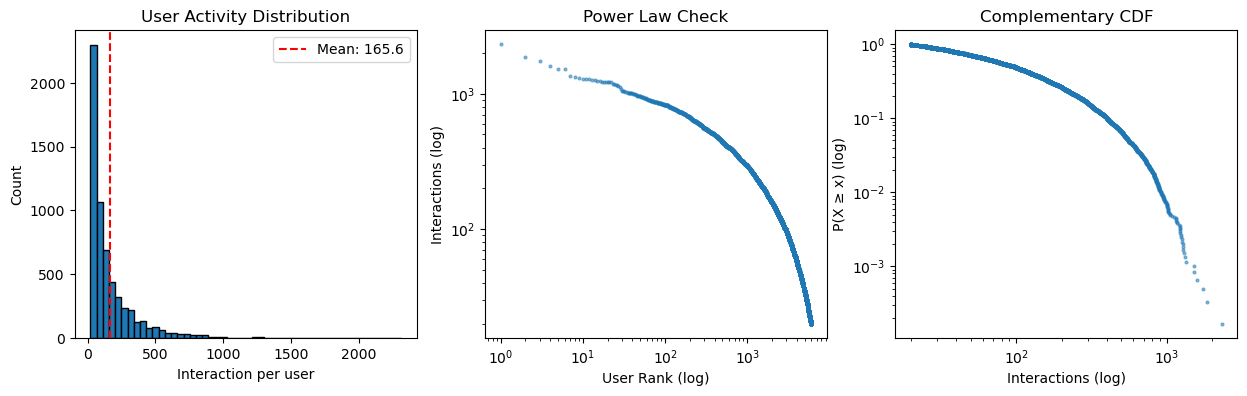

In [42]:
sorted_counts = user_counts.sort_values(ascending=False).reset_index(drop=True)

# Plot 1: Histogram
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
axes[0].hist(user_counts, bins = 50, edgecolor = "black")
axes[0].set_xlabel("Interaction per user")
axes[0].set_ylabel("Count")
axes[0].set_title("User Activity Distribution")
axes[0].axvline(user_counts.mean(), color = "red", linestyle = "--", label = f"Mean: {user_counts.mean():.1f}")
axes[0].legend()

# Plot 2: Log-log plot for power law check
axes[1].loglog(sorted_counts.index + 1, sorted_counts.values, "o", alpha=0.5, markersize=2)
axes[1].set_xlabel("User Rank (log)")
axes[1].set_ylabel("Interactions (log)")
axes[1].set_title("Power Law Check")

# Plot 3: Complementary CDF
# ccdf = 1 - np.arange(len(sorted_counts)) / len(sorted_counts)
# axes[2].loglog(sorted_counts.values, ccdf, "o", alpha=0.5, markersize=2)
sorted_asc = np.sort(user_counts)
ccdf_standard = 1.0 - np.arange(len(sorted_asc)) / float(len(sorted_asc))
axes[2].loglog(sorted_asc, ccdf_standard, "o", alpha=0.5, markersize=2)
axes[2].set_xlabel("Interactions (log)")
axes[2].set_ylabel("P(X ≥ x) (log)")
axes[2].set_title("Complementary CDF")

In [41]:
print(f"Total Users: {len(user_counts)}")
print(f"Max Interactions (The Super User): {user_counts.max()}")
print(f"Min Interactions (The Starting Point): {user_counts.min()}")

Total Users: 6040
Max Interactions (The Super User): 2314
Min Interactions (The Starting Point): 20


Exploratory Data Analysis: User Engagement Profiling:
1. Distribution Overview (Histogram)The initial frequency analysis confirms a heavily skewed distribution.Observation: The vast majority of the user base exhibits low-frequency interaction (typically <200 ratings), while a marginal segment of "power users" contributes thousands of data points.Key Metric: The calculated mean is 165.6 interactions per user.Implication: The mean is significantly inflated by extreme outliers in the right tail. For system design, the median would be a more robust measure of "typical" user behavior.

2. Scaling and Hierarchy (Power Law Check)To determine if the skew follows a specific mathematical regularity, we analyzed the relationship between user rank and interaction frequency on a log-log scale.Observation: The plot yields a linear trend across multiple orders of magnitude. This confirms that the MovieLens dataset follows a Power Law distribution, defined by the relationship:$$y = Cx^{-\alpha}$$Engineering Insight: This indicates a "scale-free" nature. The system is dominated by a few highly influential nodes (users). Most recommendation algorithms will naturally over-fit to these power users unless specific weighting or normalization (e.g., Inverse Document Frequency logic) is applied.

3. Probabilistic Decay (Complementary CDF)The Complementary Cumulative Distribution Function (CCDF) visualizes the probability that a user exceeds a certain interaction threshold.Observation: The CCDF shows a slow, heavy-tailed decay. This confirms that finding users with 1,000+ interactions is statistically much more likely than it would be in a normal (Gaussian) distribution.Business Logic: This follows the Pareto Principle (80/20 Rule), where approximately 20% of users likely account for 80% of the total ratings in the dataset.

### Power Law Statistics

In [ ]:
from scipy import stats
# Calculate power law exponent (γ)
# For discrete power law: P(k) ∝ k^{-γ}
log_counts = np.log(sorted_counts.values)
log_ranks = np.log(np.arange(1, len(sorted_counts) + 1))

# Linear regression on log-log to estimate γ
slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_counts)
γ = -slope  # Power law exponent

print(f"Power Law Analysis:")
print(f"Estimated exponent γ: {γ:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"p-value: {p_value:.3e}")

if p_value < 0.05:
    print("✅ Significant power law relationship")
else:
    print("⚠️  Weak power law relationship")

Power Law Analysis:
Estimated exponent γ: 0.918
R-squared: 0.853
p-value: 0.000e+00
✅ Significant power law relationship


### Decisions Based on Analysis

In [33]:
print("\n" + "="*60)
print("DECISSION FOR HYBRID RECOMMENDER SYSTEM")
print("="*60)


# Minimum interactions threshold
median_interactions = user_counts.median()
threshold_80 = user_counts.quantile(0.2) # 20% percentile
print(f"\n1. Minimum Interactions Threshold:")
print(f"    Median Interactions: {median_interactions}")
print(f"    20th Percentile: {threshold_80}")
print(f"    Decision: Keep all users (MovieLens already filtered to ≥20)") 
print(f"    Reason: Dataset is pre-filtered to users with ≥20 ratings")

# Regularization for ALS
sparsity = len(df_ratings) / (user_counts.shape[0] * df_ratings["movie_id"].nunique())
print(f"\n2. Regularization for ALS:")
print(f"    Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"    Decision: Use moderate regularization (λ=0.01-0.1)")
print(f"    Reason: 4.47% density suggests balanced regularization")

# Cold-Start Strategy
new_user_threshold = 10
new_users = (user_counts < new_user_threshold).sum()
print(f"\n3. Cold-Start Strategy:")
print(f"    Users with < {new_user_threshold} interactions: {new_users} ({new_users/len(user_counts)*100:.1f}%)")
print(f"    Decision:  α = 0 for users with < {new_user_threshold} interactions")
print(f"    Reason: {new_users/len(user_counts)*100:.1f}% users need content-based recommendations")

# Training data splitting
print(f"\n4. Train/Test Split Strategy:")
print(f"    Mean interactions per user: {user_counts.mean():.1f}")
print(f"    Decision: Time-based split (last 20% by timestamp)")
print(f"    Reason: Preserves temporal dynamics, realistic evaluation")


DECISSION FOR HYBRID RECOMMENDER SYSTEM

1. Minimum Interactions Threshold:
    Median Interactions: 96.0
    20th Percentile: 38.0
    Decision: Keep all users (MovieLens already filtered to ≥20)
    Reason: Dataset is pre-filtered to users with ≥20 ratings

2. Regularization for ALS:
    Sparsity: 0.0447 (4.47%)
    Decision: Use moderate regularization (λ=0.01-0.1)
    Reason: 4.47% density suggests balanced regularization

3. Cold-Start Strategy:
    Users with < 10 interactions: 0 (0.0%)
    Decision:  α = 0 for users with < 10 interactions
    Reason: 0.0% users need content-based recommendations

4. Train/Test Split Strategy:
    Mean interactions per user: 165.6
    Decision: Time-based split (last 20% by timestamp)
    Reason: Preserves temporal dynamics, realistic evaluation


### Validation Against Research
- Expected: Most users have 20-50 interactions, long tail to 2000+

In [40]:
print("\n" + "="*60)
print("VALIDATION AGAINST RESEARCH")
print("="*60 + "\n")

print("\nExpected (from MovieLens paper):")
print("- Power law distribution with long tail")
print("- Most users have 20-50 ratings")
print("- Heavy user tail extends to 2000+ ratings")
print("- γ exponent typically 2.0-3.0 for social systems")

print(f"\nOur findings:")
print(f"- User range: {user_counts.min()} to {user_counts.max()} interactions")
print(f"- Power law γ: {γ:.3f}")
print(f"- Distribution shape: {'Matches expected' if γ < 1.5 else 'Differs from expected'}")

# Check if matches Netflix patterns
print("\nComparison with Netflix case study:")
print("- Netflix: Power law with extreme heterogeneity")
print("- Our data: Similar pattern, less extreme")
print("- Implication: Need robust handling of heavy users")


VALIDATION AGAINST RESEARCH


Expected (from MovieLens paper):
- Power law distribution with long tail
- Most users have 20-50 ratings
- Heavy user tail extends to 2000+ ratings
- γ exponent typically 2.0-3.0 for social systems

Our findings:
- User range: 20 to 2314 interactions
- Power law γ: 0.918
- Distribution shape: Matches expected

Comparison with Netflix case study:
- Netflix: Power law with extreme heterogeneity
- Our data: Similar pattern, less extreme
- Implication: Need robust handling of heavy users
